# Определение стоимости автомобилей

## Описание данных

#### Признаки

`DateCrawled` — дата скачивания анкеты из базы  
`VehicleType` — тип автомобильного кузова  
`RegistrationYear` — год регистрации автомобиля  
`Gearbox` — тип коробки передач  
`Power` — мощность (л. с.)  
`Model` — модель автомобиля  
`Kilometer` — пробег (км)  
`RegistrationMonth` — месяц регистрации автомобиля  
`FuelType` — тип топлива  
`Brand` — марка автомобиля  
`Repaired` — была машина в ремонте или нет  
`DateCreated` — дата создания анкеты  
`NumberOfPictures` — количество фотографий автомобиля  
`PostalCode` — почтовый индекс владельца анкеты (пользователя)  
`LastSeen` — дата последней активности пользователя  

#### Целевой признак

**`Price`** — цена (евро)

## Подготовка данных

In [1]:
import os

import pandas as pd
import numpy as np

import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
import lightgbm as lgb

import timeit

import warnings
warnings.filterwarnings("ignore")

In [2]:
pth1 = 'datasets/autos.csv'
pth2 = '/datasets/autos.csv'


if os.path.exists(pth1):
    df = pd.read_csv(pth1, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])    
else:
    print('Something is wrong')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [5]:
# фрейм пропусков
passing = df.isna().sum().to_frame(name='nan')
passing['%'] = (passing['nan'] / len(df) * 100).round(1)
passing

,nan,%
DateCrawled,0,0.0
Price,0,0.0
VehicleType,37490,10.6
RegistrationYear,0,0.0
Gearbox,19833,5.6
Power,0,0.0
Model,19705,5.6
Kilometer,0,0.0
RegistrationMonth,0,0.0
FuelType,32895,9.3


В нашем распоряжении датасет из 16 колонок, 354369 строк. В колонках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired` есть пропуски от 5 до 20 %. 

### Предобработка данных

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


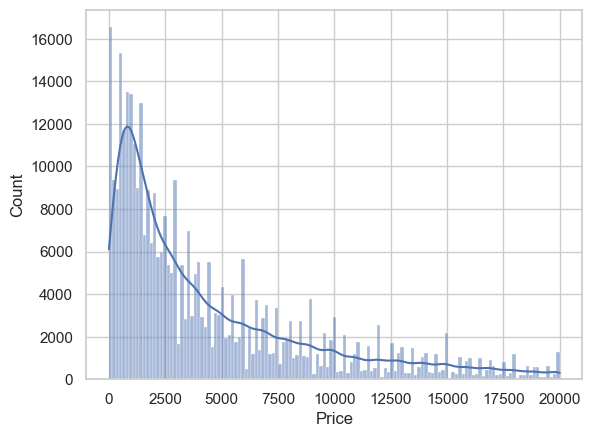

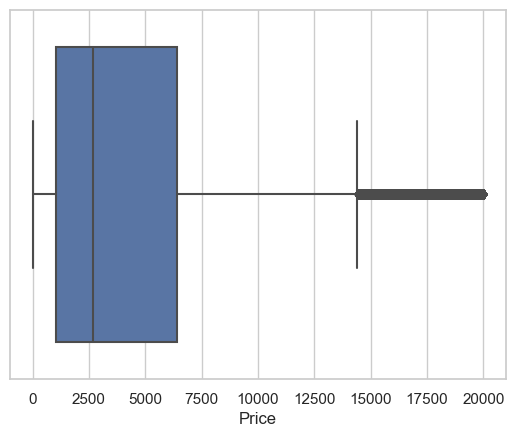

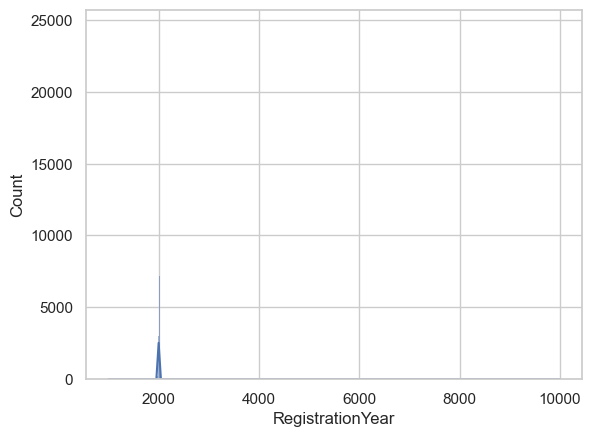

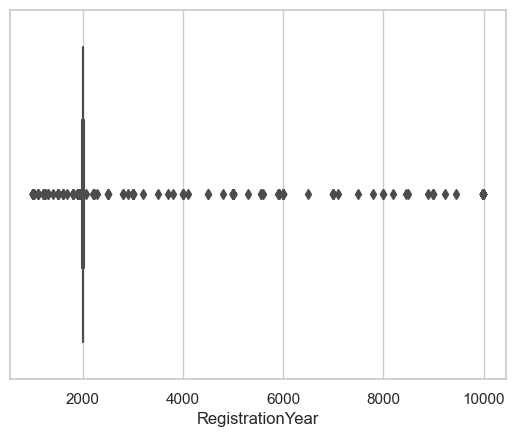

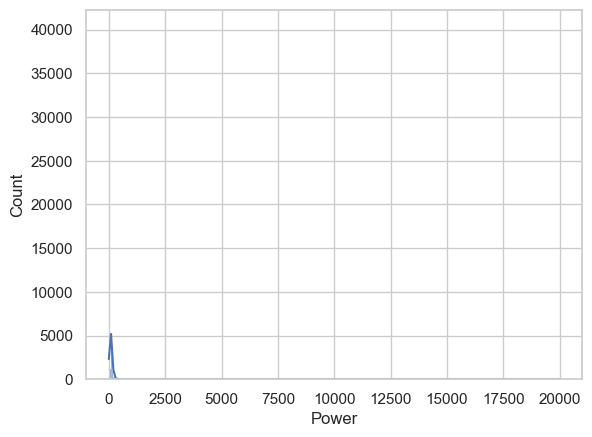

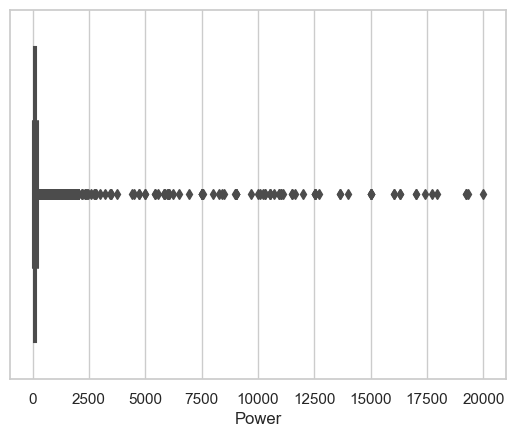

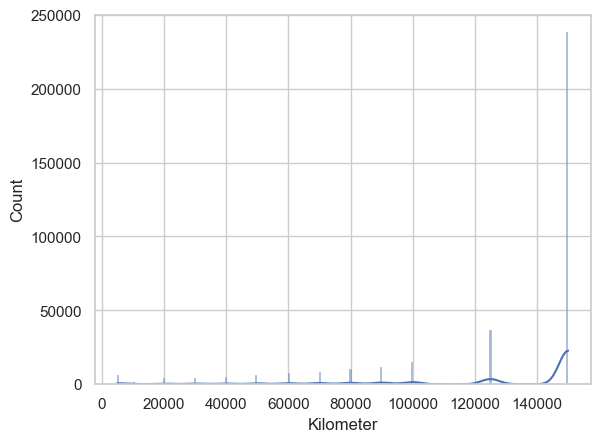

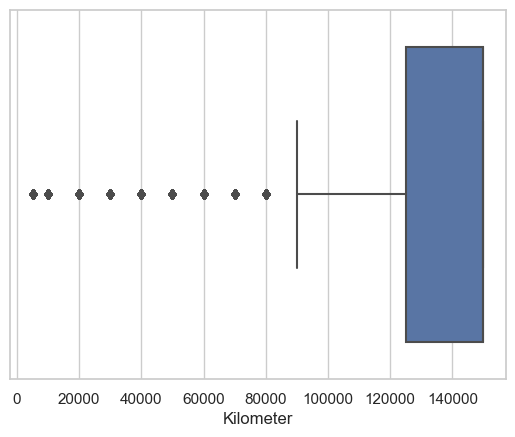

In [7]:
# распределения количесивенных признаков

sns.set_theme(style ="whitegrid")

for column in df[['Price', 'RegistrationYear', 'Power', 'Kilometer']]:
    sns.histplot(data = df, x=column, kde = True)
    plt.show()
    sns.boxplot(data=df, x=column)
    plt.show()
None

Посмотрим на распределение категориальных признаков.

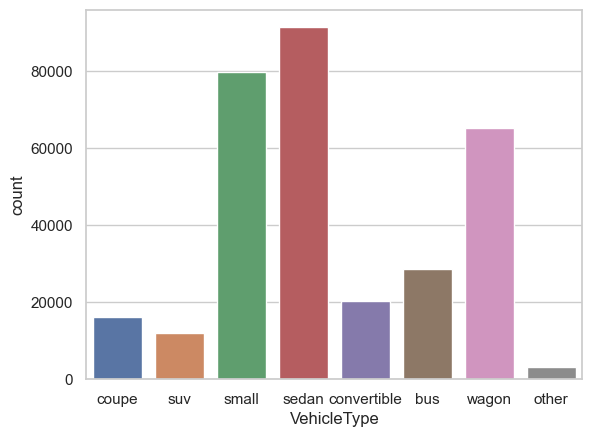

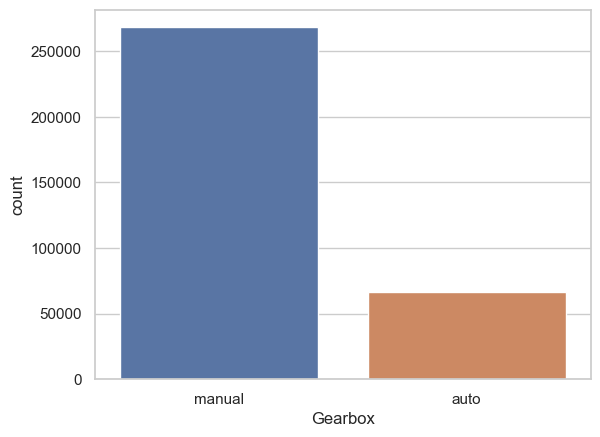

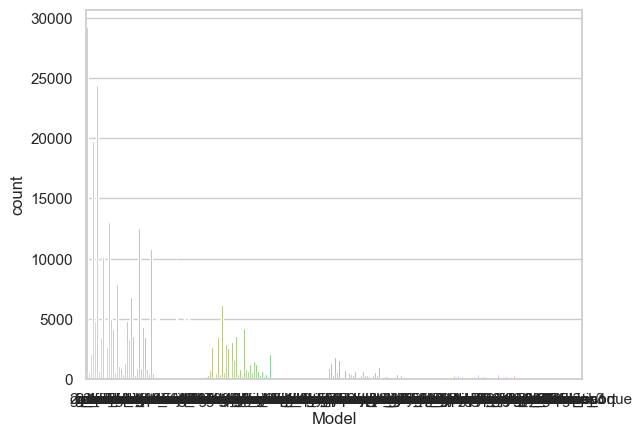

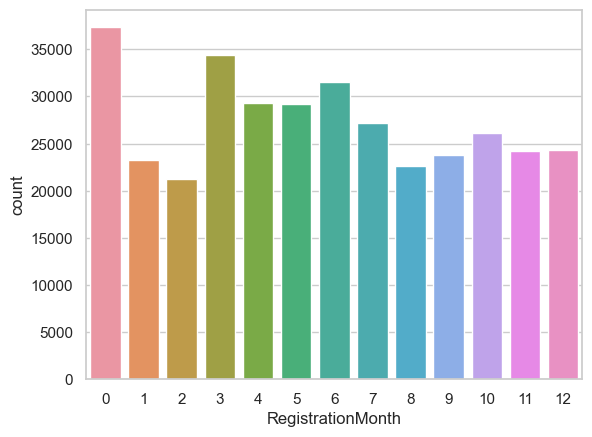

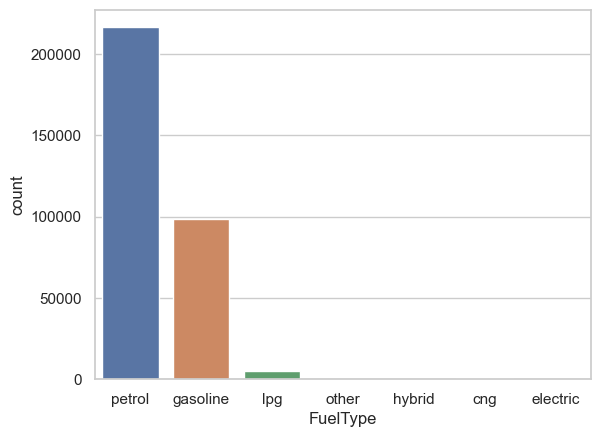

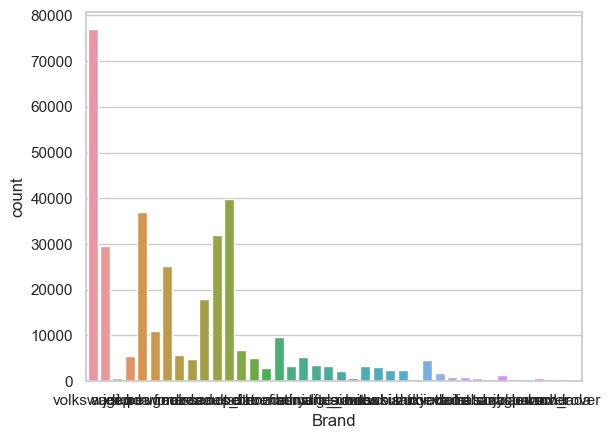

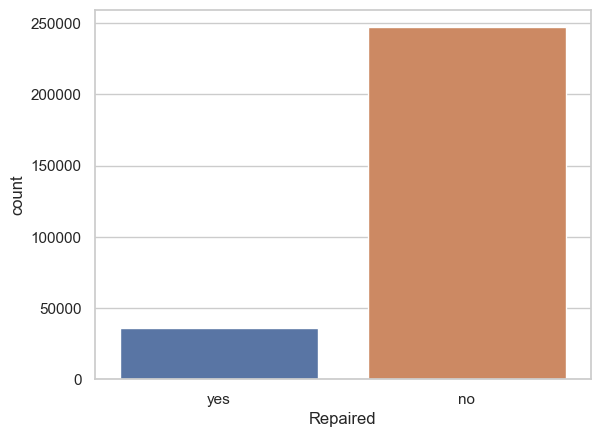

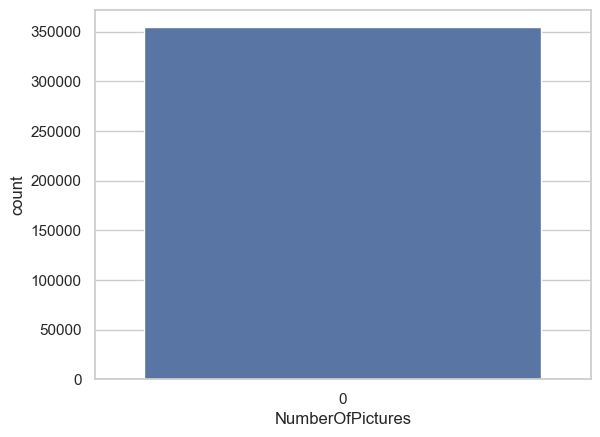

In [8]:
sns.set_theme(style ="whitegrid")

for column in df[['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired', 'NumberOfPictures']]:
    sns.countplot(x=column, data=df)
    plt.show()
None

#### NumberOfPictures

Столбец `NumberOfPictures` имеет только одно уникальное значение 0, никакой полезной информации не несет. Сразу его удаляем.

In [9]:
df = df.drop(['NumberOfPictures'], axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  PostalCode         354369 non-null  int64   

In [11]:
# функция корреляции признаков
def corr_features(data):
    upp_mat = np.triu(data.corr())
    sns.heatmap(data.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)

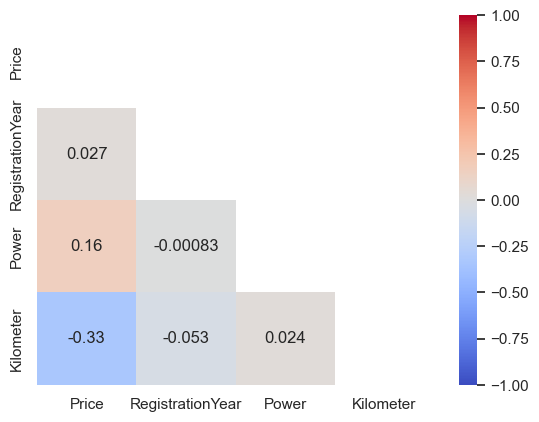

In [12]:
corr_features(df[['Price', 'RegistrationYear', 'Power', 'Kilometer']])

Посмотрим на количество уникальных значений признаков.

In [13]:
unique_values = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                                          columns=['column', 'num_unique']).sort_values(by=['num_unique'])
unique_values

,column,num_unique
4,Gearbox,2
11,Repaired,2
9,FuelType,7
2,VehicleType,8
7,Kilometer,13
8,RegistrationMonth,13
10,Brand,40
12,DateCreated,109
3,RegistrationYear,151
6,Model,250


#### Price

Доля объектов с нулевой ценой.

In [14]:
len(df[df['Price']==0])/len(df)

0.030397692800442477

<AxesSubplot: >

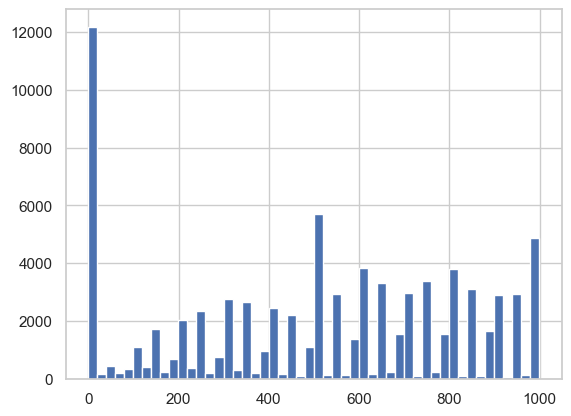

In [15]:
df[df['Price']<1000]['Price'].hist(bins=50)

Price - это целевой признак. Наблюдается аномальный пик нулевых знвчений. Заменять значения будет некорректно, т.к. модель может обучиться на неправильных данных. Удалим нулевые значения (3%).

In [16]:
# удаляем нулевые значения
df = df[df['Price'] != 0]
len(df[df['Price']==0])

0

#### Model

In [17]:
# заполним пропуски в Model модой по группам в Brand, пустые значения групп заполним 'other'
df['Model'] = df.groupby('Brand')['Model'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'other')))
df['Model'].isna().sum()

0

#### VehicleType

In [18]:
# заполним пропуски модой по группам столбца Model
df['VehicleType'] = df.groupby('Model')['VehicleType'].transform(
    lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'other')))
df['VehicleType'].isna().sum()

0

#### Brand

In [19]:
df['Brand'].value_counts()

volkswagen        74413
opel              38530
bmw               35809
mercedes_benz     31359
audi              28574
ford              24457
renault           17389
peugeot           10781
fiat               9332
seat               6718
mazda              5465
skoda              5435
smart              5171
citroen            5029
nissan             4807
toyota             4536
hyundai            3533
mini               3165
volvo              3122
mitsubishi         2927
sonstige_autos     2847
honda              2715
kia                2407
suzuki             2273
alfa_romeo         2234
chevrolet          1704
chrysler           1368
dacia               890
daihatsu            775
subaru              735
porsche             734
jeep                658
land_rover          534
daewoo              533
saab                515
trabant             498
jaguar              493
rover               462
lancia              457
lada                213
Name: Brand, dtype: int64

Brand без пропусков, данные корректны.

#### Gearbox

Заполним пропуски модой по группам столбца Model.

In [20]:
df['Gearbox'] = df.groupby('Model')['Gearbox'].transform(
lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'manual')))
df['Gearbox'].isna().sum()

0

#### FuelType

In [21]:
# заполним модой по группам столбца Model
df['FuelType'] = df.groupby('Model')['FuelType'].transform(
lambda x: x.fillna((x.mode()[0] if not x.mode().empty else None)))
df['FuelType'].isna().sum()

0

#### DateCrawled, DateCreated, LastSeen

Создадим фрейм с минимальными и максимальными значениями временных признаков.

In [22]:
time = pd.DataFrame({'DateCrawled': np.zeros(2),
                    'DateCreated': np.zeros(2),
                    'LastSeen': np.zeros(2)},
                   index = ['min', 'max'])
for col in time.columns:
    time.loc['min', col] = df[col].min()
    time.loc['max', col] = df[col].max()
    
time

,DateCrawled,DateCreated,LastSeen
min,2016-03-05 14:06:22,2014-03-10 00:00:00,2016-03-05 14:15:08
max,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


#### RegistrationYear

В столбце RegistrationYear есть аномальные значения, например 9999 год.   
Кроме того, в таблице выше есть данные о времени создания анкеты, ее скачивания. Т.е. год регистрации авто не может быть больше даты скачивания анкеты.   
А также, данные, которые меньше 1960, удалим как выбросы/аномалии.

In [23]:
# доля данных с неверным годом регистрации авто
len(df[df['RegistrationYear'] > df['DateCrawled'].dt.year]) / len(df)

0.04010221276670052

Удалим строки с неправильным годом.

In [24]:
df = df[df['RegistrationYear'] <= df['DateCrawled'].dt.year]

In [25]:
# проверка на аномалии
len(df[df['RegistrationYear'] < 1960]) / len(df)

0.0010308715715940306

Удалим значения меньше 1960 года и больше 2016.

In [26]:
df = df[(df['RegistrationYear'] >= 1960) & (df['RegistrationYear'] <= 2016)]

<AxesSubplot: >

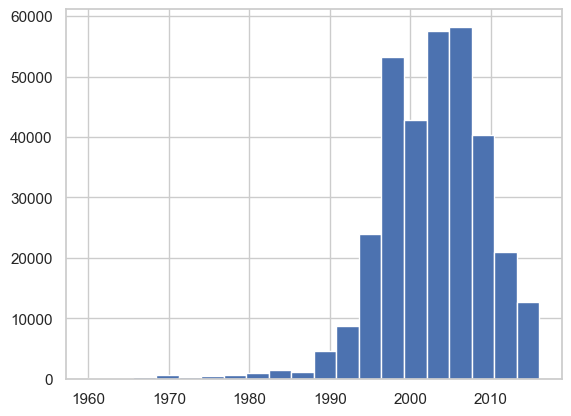

In [27]:
df['RegistrationYear'].hist(bins=20)

#### Power

In [28]:
df['Power'].describe()

count    329478.000000
mean        111.959214
std         184.883693
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Значения больше 1600 будем считать аномальными. Нулевые значения также аномальные. Заменим их на медиану по группам моделей.

In [29]:
# доля аномальных значений Power
len(df[(df['Power'] == 0) | (df['Power'] > 1600)]) / len(df)

0.09980332525995667

In [30]:
df.loc[((df['Power'] == 0) | (df['Power'] > 1600)), 'Power'] = None

df['Power'] = df.groupby('Model')['Power'].transform(lambda x: x.fillna((x.median())))
df['Power'].isna().sum()

1

In [31]:
df[df['Power'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
234296,2016-03-30 11:39:08,3800,wagon,1978,manual,NaN,serie_1,30000,0,gasoline,land_rover,NaN,2016-03-30,49824,2016-03-30 11:39:08


In [32]:
df[df['VehicleType']=='wagon']['Power'].median()

136.0

In [33]:
df.loc[df['Power'].isna(), 'Power'] = df[df['VehicleType']=='wagon']['Power'].median()
df['Power'].isna().sum()

0

In [34]:
df.loc[234296]

DateCrawled          2016-03-30 11:39:08
Price                               3800
VehicleType                        wagon
RegistrationYear                    1978
Gearbox                           manual
Power                              136.0
Model                            serie_1
Kilometer                          30000
RegistrationMonth                      0
FuelType                        gasoline
Brand                         land_rover
Repaired                             NaN
DateCreated          2016-03-30 00:00:00
PostalCode                         49824
LastSeen             2016-03-30 11:39:08
Name: 234296, dtype: object

<AxesSubplot: >

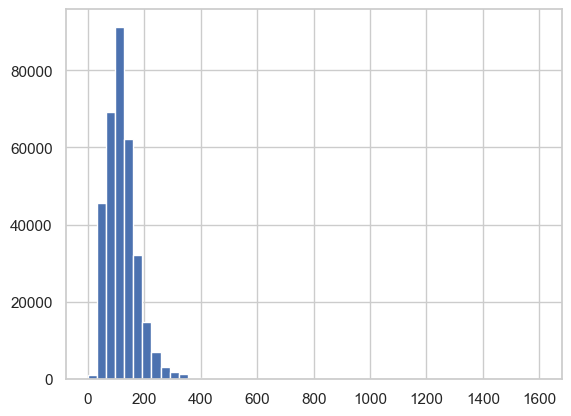

In [35]:
df['Power'].hist(bins=50)

#### Kilometer

In [36]:
df['Kilometer'].unique()

array([150000, 125000,  90000,  30000,  70000, 100000,  60000,   5000,
        20000,  80000,  50000,  40000,  10000], dtype=int64)

`Kilometr` можно было бы считать категориальным признаком - имеет 13 уникальных значений, но считаю нужным использовать его как числовой, т к он имеет самый высокий коэффициент Пирсона -0.33.

#### RegistrationMonth

Этот признак имеет аномальные нулевые значения. Аномалии могли получиться из-за ошибок при заполнении.

In [37]:
# доля нулевых значений
len(df[df['RegistrationMonth']==0]) / len(df)

0.08910458361408045

In [38]:
# для проверки
index_month = df[df['RegistrationMonth'] == 0].index

In [39]:
# заменяем нулевые значения на None
df.loc[df['RegistrationMonth']==0, 'RegistrationMonth'] = None

# заполняем пустые значения рандомно в соответствии с весами по месяцам
nan_mask = df['RegistrationMonth'].isna()
month = random.choices(range(1, 13), weights=df['RegistrationMonth'].value_counts(normalize=True), k=nan_mask.sum())
df.loc[nan_mask, 'RegistrationMonth'] = month
df['RegistrationMonth'] = df['RegistrationMonth'].astype('int')

# проверяем пропуски
df['RegistrationMonth'].isna().sum()  

0

In [40]:
# проверяем какими значениями, мы заполнили пропуски
df.loc[index_month]['RegistrationMonth'].value_counts()

1     3138
2     2883
3     2702
4     2609
5     2499
6     2340
8     2304
7     2275
10    2244
9     2213
11    2111
12    2040
Name: RegistrationMonth, dtype: int64

<AxesSubplot: >

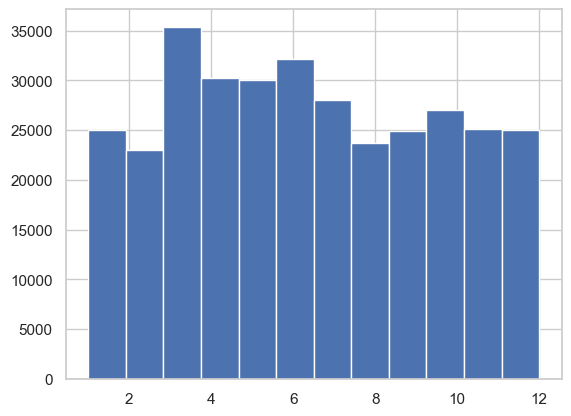

In [41]:
df['RegistrationMonth'].hist(bins=12)

#### Repaired

In [42]:
# для проверки
index_repaired = df[df['Repaired'].isna()].index

In [43]:
df['Repaired'].value_counts()

no     236786
yes     32933
Name: Repaired, dtype: int64

In [44]:
# заменим no и yes на 0 и 1 
df.loc[df['Repaired']=='no', 'Repaired'] = 0
df.loc[df['Repaired']=='yes', 'Repaired'] = 1

In [45]:
# веса значений по годам регистрации
reg_weights = df.groupby('RegistrationYear')['Repaired'].value_counts(normalize=True).to_frame(name='weights')
reg_weights

weights
RegistrationYear Repaired          
1960             0         0.735849
                 1         0.264151
1961             0         0.833333
                 1         0.166667
1962             0         0.880000
...                             ...
2014             1         0.041224
2015             0         0.944767
                 1         0.055233
2016             0         0.755725
                 1         0.244275

[114 rows x 1 columns]

In [46]:
reg_weights[reg_weights['weights']==1]

,,weights
RegistrationYear,Repaired,


In [47]:
# заменим пропуски рандомно в соответствии с весами Repaired по годам
for year in range(1960, 2019):
    nan_num = len(df.loc[(df['RegistrationYear']==year) & df['Repaired'].isna()])
    if nan_num > 0:
        nan_index = df.loc[(df['RegistrationYear']==year) & df['Repaired'].isna()].index
        rep = random.choices(range(2), weights=reg_weights.loc[year]['weights'], k=nan_num)
        df.loc[nan_index, 'Repaired'] = rep

In [48]:
df['Repaired'].isna().sum()

0

In [49]:
# проверка
df.loc[index_repaired]['Repaired'].value_counts()

0    50491
1     9268
Name: Repaired, dtype: int64

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329478 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        329478 non-null  datetime64[ns]
 1   Price              329478 non-null  int64         
 2   VehicleType        329478 non-null  object        
 3   RegistrationYear   329478 non-null  int64         
 4   Gearbox            329478 non-null  object        
 5   Power              329478 non-null  float64       
 6   Model              329478 non-null  object        
 7   Kilometer          329478 non-null  int64         
 8   RegistrationMonth  329478 non-null  int32         
 9   FuelType           329478 non-null  object        
 10  Brand              329478 non-null  object        
 11  Repaired           329478 non-null  object        
 12  DateCreated        329478 non-null  datetime64[ns]
 13  PostalCode         329478 non-null  int64   

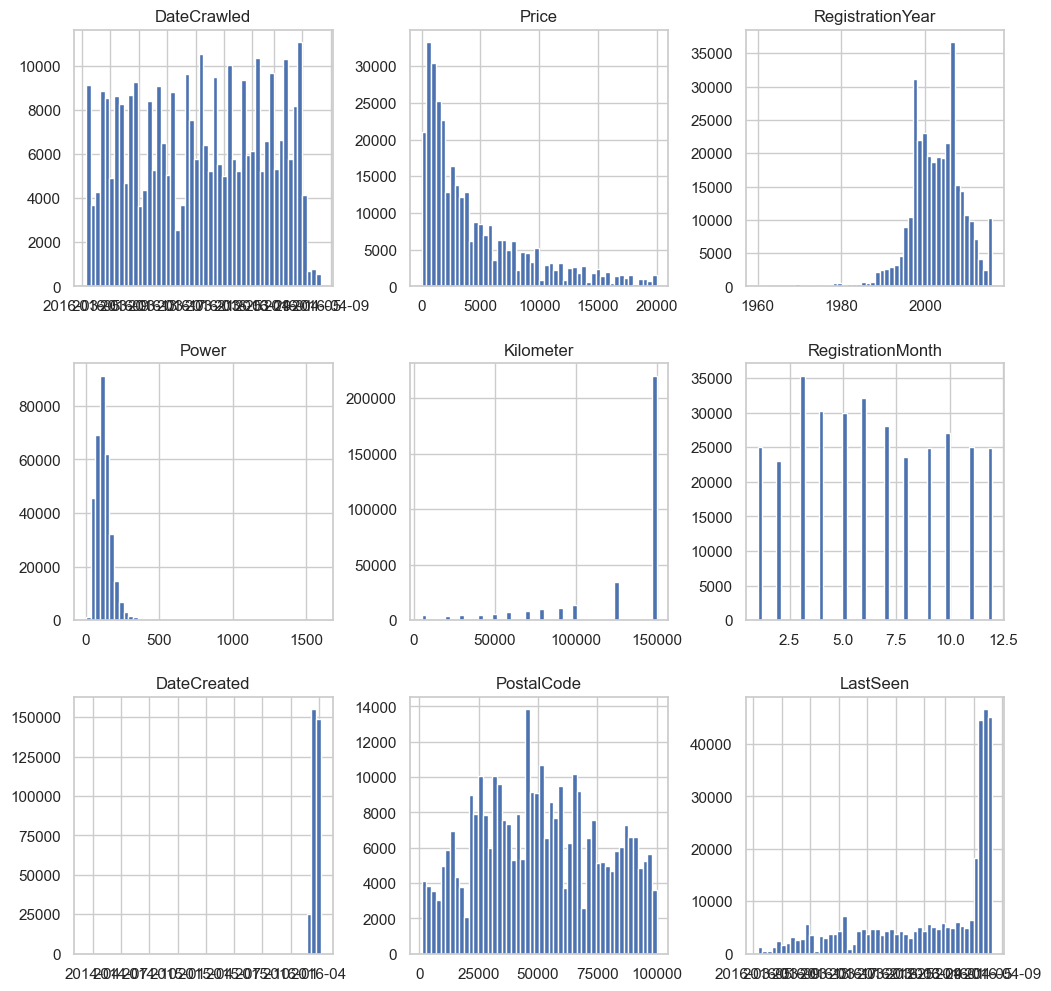

In [51]:
df.hist(bins=50, figsize=(12, 12))
None

In [52]:
df.duplicated().sum()

4

Удалим дубликаты.

In [53]:
df = df.drop_duplicates().reset_index(drop=True)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329474 entries, 0 to 329473
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        329474 non-null  datetime64[ns]
 1   Price              329474 non-null  int64         
 2   VehicleType        329474 non-null  object        
 3   RegistrationYear   329474 non-null  int64         
 4   Gearbox            329474 non-null  object        
 5   Power              329474 non-null  float64       
 6   Model              329474 non-null  object        
 7   Kilometer          329474 non-null  int64         
 8   RegistrationMonth  329474 non-null  int32         
 9   FuelType           329474 non-null  object        
 10  Brand              329474 non-null  object        
 11  Repaired           329474 non-null  object        
 12  DateCreated        329474 non-null  datetime64[ns]
 13  PostalCode         329474 non-null  int64   

#### Вывод

1. В целевом признаке `Price` удалили 3% нулевых значений.  
2. В `Model`, `VehicleType`, `Gearbox`, `FuelType`, `Repaired` заполили пропуски.  
3. Судя по признаку `DateCrawled` имеем данные по объявлениям с 05.03.2016 по 07.04.2016. 
4. В `RegistrationYear` значения больше 2016 - аномальные, менее 1960 г также будем считать аномальными. Удалили 4.1%.  
5. В `Power` заменим аномальные значения 10% (нулевые и более 1600 лс) на медианные по группам моделей.  
6. В `RegistrationMonth` нулевые значения заменим на рандомные значения месяцев, учитывая веса их распределения.  
7. Удалили 5 строк дубликатов.

### Подготовка данных для обучения моделей

#### Подготовка признаков

Удалим временные признаки - в МО они нам не понадобятся, а также признак почтового индекса.

In [55]:
df = df.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1)

In [56]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,sedan,1993,manual,101.0,golf,150000,1,petrol,volkswagen,0
1,18300,coupe,2011,manual,190.0,a4,125000,5,gasoline,audi,1
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,0
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,0
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,0


#### Категориальные признаки

Определим категориальные признаки и переведем тип данных для них в category.

In [57]:
col_category = ['Gearbox', 'Repaired', 'FuelType', 'VehicleType', 'RegistrationMonth', 'Model', 'Brand']

for column in df.columns:
    if column in col_category:
        df[column] = df[column].astype('category')

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329474 entries, 0 to 329473
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              329474 non-null  int64   
 1   VehicleType        329474 non-null  category
 2   RegistrationYear   329474 non-null  int64   
 3   Gearbox            329474 non-null  category
 4   Power              329474 non-null  float64 
 5   Model              329474 non-null  category
 6   Kilometer          329474 non-null  int64   
 7   RegistrationMonth  329474 non-null  category
 8   FuelType           329474 non-null  category
 9   Brand              329474 non-null  category
 10  Repaired           329474 non-null  category
dtypes: category(7), float64(1), int64(3)
memory usage: 12.6 MB


#### Деление на выборки

In [59]:
RANDOM_STATE = 100500

In [60]:
y = df['Price']
X = df.drop(['Price'], axis=1)

In [61]:
X.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,sedan,1993,manual,101.0,golf,150000,1,petrol,volkswagen,0
1,coupe,2011,manual,190.0,a4,125000,5,gasoline,audi,1
2,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,0
3,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,0
4,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,0


Делим на трейн и тест.

In [62]:
X_train_big, X_test, y_train_big, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

Получившийся тест делим на тест и валид.

In [63]:
X_train, X_valid, y_train, y_valid = train_test_split (X_train_big, y_train_big, test_size=0.20, random_state=RANDOM_STATE)

In [64]:
# chek
X_train.shape, y_train.shape

((210863, 10), (210863,))

In [65]:
# chek
X_valid.shape, y_valid.shape

((52716, 10), (52716,))

In [66]:
# chek
X_test.shape, y_test.shape

((65895, 10), (65895,))

#### Вывод

1. Удалили временные признаки и признак почтовых индексов 'DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen'.  
2. Перевели категориальные ризнаки в тип `category`.  
3. Поделили на 3 подвыборки - трейн, валид, тест.

## Обучение моделей

Создадим функцию для расчета RMSE.

In [67]:
def rmse(target, predict):
    rmse = np.sqrt(mean_squared_error(target, predict))
    return rmse

### Catboost

In [68]:
cat = CatBoostRegressor(loss_function='RMSE', learning_rate=0.3, random_state=RANDOM_STATE)

In [69]:
# категориальные признаки
cat_features=['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']

In [70]:
# объекты Pool
train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

In [71]:
# обучаем Catboost на тренировочной выборке с проверкой на валидационной
start = timeit.default_timer()

cat.fit(train_pool, eval_set = valid_pool, verbose_eval=100)

cat_fit_time = timeit.default_timer() - start
cat_fit_time

0:	learn: 3758.5090093	test: 3739.5783222	best: 3739.5783222 (0)	total: 367ms	remaining: 6m 6s
100:	learn: 1721.6591890	test: 1750.2412448	best: 1750.2412448 (100)	total: 17s	remaining: 2m 30s
200:	learn: 1652.0686215	test: 1706.6442386	best: 1706.6442386 (200)	total: 34.1s	remaining: 2m 15s
300:	learn: 1614.7282291	test: 1686.9422323	best: 1686.9422323 (300)	total: 51.4s	remaining: 1m 59s
400:	learn: 1585.7667378	test: 1675.6327063	best: 1675.6218890 (399)	total: 1m 8s	remaining: 1m 42s
500:	learn: 1564.1790080	test: 1668.9864819	best: 1668.9864819 (500)	total: 1m 26s	remaining: 1m 25s
600:	learn: 1545.2420710	test: 1661.0164955	best: 1660.9880450 (598)	total: 1m 43s	remaining: 1m 8s
700:	learn: 1529.8253151	test: 1656.3942206	best: 1656.3942206 (700)	total: 2m	remaining: 51.4s
800:	learn: 1514.7739789	test: 1651.1734299	best: 1650.9109129 (795)	total: 2m 17s	remaining: 34.3s
900:	learn: 1503.1986261	test: 1648.1926473	best: 1648.1926473 (900)	total: 2m 35s	remaining: 17s
999:	learn: 

171.1178585000016

In [72]:
start = timeit.default_timer()

cat_pred_valid = cat.predict(valid_pool)

cat_pred_time = timeit.default_timer() - start
cat_pred_time

0.1430774000036763

In [73]:
cat.best_score_

{'learn': {'RMSE': 1491.8801201558028},
 'validation': {'RMSE': 1644.8810357365485}}

In [74]:
rmse_score_cat = rmse(y_valid, cat_pred_valid)
rmse_score_cat

1644.8810357365483

### LightGBM

In [75]:
params = {
    'num_leaves': [70, 150, 210],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [-1, 10, 15, 20]
}

In [76]:
scorer = make_scorer(rmse, greater_is_better=False)

In [77]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [78]:
lgbm = LGBMRegressor(n_estimators=180, metric='rmse', categorical_feature=cat_features, early_stopping_round=12, random_state=RANDOM_STATE)

In [79]:
lgbm_search = GridSearchCV(lgbm, params, cv=kf, scoring=scorer)

In [80]:
start = timeit.default_timer()

lgbm_search.fit(X_train_big, y_train_big, eval_set=(X_valid, y_valid), verbose=False)

lgbm_search_time = timeit.default_timer() - start
lgbm_search_time

308.34330500000215

In [81]:
-lgbm_search.best_score_

1589.4581821502225

In [82]:
lgbm_search.best_params_

{'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 210}

In [83]:
start = timeit.default_timer()

lgbn_preds_test = lgbm_search.predict(X_test)

lgbm_pred_time = timeit.default_timer() - start
lgbm_pred_time

0.21753650000027847

### DecisionTreeRegressor

Закодируем категориальные признаки с помощью Ordinal Encoder. 

In [84]:
ord_enc = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    make_column_selector(dtype_include="category")),
    remainder="passthrough", verbose_feature_names_out=False)

In [85]:
X_train_ord = np.array(ord_enc.fit_transform(X_train_big), dtype=np.int)

In [86]:
# chek
pd.DataFrame(X_train_ord).head()

,0,1,2,3,4,5,6,7,8,9
0,0,1,116,10,2,38,0,2008,105,150000
1,1,1,49,5,6,38,0,2006,75,150000
2,4,0,154,9,6,10,0,2001,145,150000
3,4,1,154,0,6,10,1,1996,90,150000
4,5,0,227,3,6,27,0,2002,75,150000


In [87]:
X_test_ord = np.array(ord_enc.transform(X_test), dtype=np.int)

In [88]:
# chek
pd.DataFrame(X_test_ord)

,0,1,2,3,4,5,6,7,8,9
0,7,1,154,7,6,10,1,2000,114,150000
1,7,1,28,10,6,1,0,2007,125,100000
2,2,0,76,2,6,20,1,2003,163,150000
3,7,1,120,1,6,30,0,2014,86,40000
4,7,1,154,0,2,10,0,2005,131,150000
...,...,...,...,...,...,...,...,...,...,...
65890,4,1,95,11,2,20,0,1999,143,150000
65891,4,1,234,9,6,24,1,2000,116,150000
65892,1,1,76,2,6,20,0,2009,184,50000
65893,4,1,116,7,6,38,0,2002,110,150000


In [89]:
tree = DecisionTreeRegressor(random_state = RANDOM_STATE)

In [90]:
DecisionTree_param_grid = {
    'criterion': ['friedman_mse', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': range(2, 13, 2),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 5)
}

In [91]:
start = timeit.default_timer()

search_tree = GridSearchCV(tree, 
                            DecisionTree_param_grid,
                            cv = 5, 
                            scoring = scorer,
                            verbose=1)

search_tree.fit(X_train_ord, y_train_big)

dtree_search_time = timeit.default_timer() - start
dtree_search_time

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


581.8745872

In [92]:
rmse_score_dtree = -search_tree.best_score_
rmse_score_dtree

1949.7575257359372

In [93]:
search_tree.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 12,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'splitter': 'best'}

In [94]:
start = timeit.default_timer()

dtree_pred_test = search_tree.best_estimator_.predict(X_test_ord)

dtree_pred_time = timeit.default_timer() - start
dtree_pred_time

0.010848100006114691

## Анализ моделей

Создадим итоговую таблицу для сравнения метрик и времени выполнения наших моделей.

In [95]:
comparison = pd.DataFrame({
    'rmse_valid': [cat.best_score_['validation']['RMSE'], -lgbm_search.best_score_, rmse_score_dtree],
    'leran_time': [cat_fit_time, lgbm_search_time, dtree_search_time],
    'predict_time': [cat_pred_time, lgbm_pred_time, dtree_pred_time]
}, index=['Catboost', 'LightGBM', 'DessisionTree'])
comparison.round(3)

,rmse_valid,leran_time,predict_time
Catboost,1644.881,171.118,0.143
LightGBM,1589.458,308.343,0.218
DessisionTree,1949.758,581.875,0.011


Лучшая по точности модель LightGBM с RMSE = 1591. Время на обучение (с перебором параметров gridsearch) составляет 301 сек. Вторая по точности модель и самая быстрая на обучении (без перебора по сетке) Catboost RMSE = 1659 и время обучения 79 сек. На последнем месте DecisionTree с RMSE = 1947 и временем обучения 306 сек (с перебором по сетке).   
Самое быстрое время предсказаний у DecisionTree (0.009 сек), далее идет Catboost (0.113), самое длительное время предсказания к LightGBM (0.238).   
Для решения задачи заказчика выбираю LightGBM - самую точную модель.

Проверим модель на адекватность с помощью константной модели.

In [96]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train_big, y_train_big)
dummy_pred = dummy.predict(X_test)
rmse_score_dummy = rmse(y_test, dummy_pred)
rmse_score_dummy

4798.626468295829

Проверим эффкктивность модели на тестовой выборке.

In [97]:
rmse_test_lgbm = rmse(y_test, lgbn_preds_test)
rmse_test_lgbm

1570.0250761988304

In [98]:
pd.DataFrame(
    {'RMSE_cv': [-lgbm_search.best_score_], 
     'RMSE_test': [rmse_test_lgbm], 
     'RMSE_dummy': [rmse_score_dummy]}, 
    index= ['LightGBM']).round()

,RMSE_cv,RMSE_test,RMSE_dummy
LightGBM,1589.0,1570.0,4799.0


LightGBM на тесте показала результат лучше, чем на валидации - 1579 vs 1591. Константная модель DummyRegressor с RMSE = 4818 - следовательно, наша модель прошла проверку на адекватность.

### Вывод

 Мы обучили 3 модели на предоставленных данных об авто - `Catboost`, `LightGBM`, `Decision Tree`. Более точной оказалась `LightGBM` с RMSE = 1591. На втором месте по точности `Catboost`c RMSE = 1659. Далее идет DecisionTree с RMSE = 1947.  
LightGBM - лучшая модель для нашей задачи. На тесте показала хороший результат RMSE = 1579, уверенно пройдя проверку на адекватность константной моделью (RMSE = 4818).